In [4]:
import os
import random
import utils.utils as utils
import DCGAN
from utils.SubsetMNIST import SubsetMNIST
#from SVM import SVM
from Networks import *
from VAE import VAE
from active_learners import *
from criterions import * 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.nn import functional as F

manual_seed = 1338
random.seed(manual_seed)
torch.manual_seed(manual_seed)
print(torch.__version__)

0.4.1


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
datafolder = './data'
classes = [5,7]

trans = transforms.Compose([transforms.Pad(2), # pad MNIST images to 32x32
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,)), # rescale images to [-1,1] for tanh in GAN
                           ])

train_set = SubsetMNIST(root=datafolder,classes=classes, re_label=True, train=True, transform=trans)
test_set = SubsetMNIST(root=datafolder,classes=classes, re_label=True, train=False, transform=trans)

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set),
                                         shuffle=False, num_workers=1)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False, num_workers=1)

X_train,y_train = next(iter(train_loader))

In [4]:
vae2 = torch.load('./models/MNIST_5_7/VAE_2.pth.tar',map_location=device)
latent_dim = 2
vae2.eval()
with torch.no_grad():
    z_train,_ = vae2.encode(X_train.view(X_train.shape[0],-1))
    print(z_train.shape)
vae2_dset = torch.utils.data.TensorDataset(
    torch.tensor(X_train,dtype=torch.float),
    torch.tensor(z_train,dtype=torch.float),
    torch.tensor(y_train,dtype=torch.long))

torch.Size([11686, 2])


In [5]:
from experiment_scripts import experiment

kwargs = {
        'model': LeNet,
        'model_kwargs': {'output_dim': 10},
        'train_set': vae2_dset,
        'test_loader': test_loader,
        'rounds': 1,
        'iters': 50,
        'initially_labeled': 5,
        'inital_training_epochs': 25,
        're_training_epochs': 25,
        'hard': True,
        'temp': 0,
        'print_freq': 10,
        'plot': True,
        'plot_densfct': MultivariateLogProb(latent_dim),
    }


In [6]:
result_folder = './experiment_results/MNIST_5_7_vae2/'

try:
    os.makedirs(result_folder)
except FileExistsError:
    pass

In [7]:
def experiments_mnist(learner,criterion,name):
        out = experiment(learner,criterion=criterion, **kwargs)

        utils.save_obj(out,result_folder+name)

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.6250 | Val loss 0.5850 


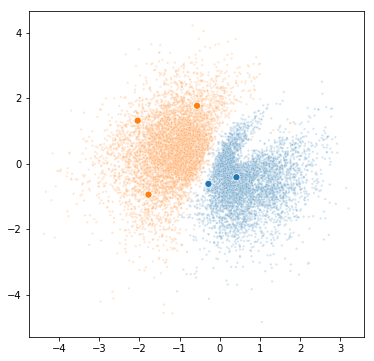

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.8906 | Val loss 0.2895 


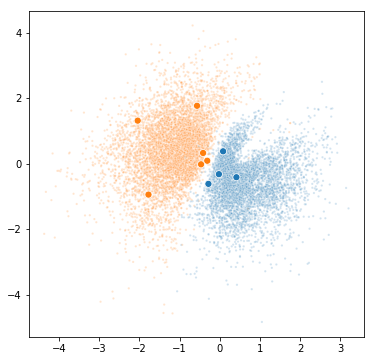

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9505 | Val loss 0.2184 


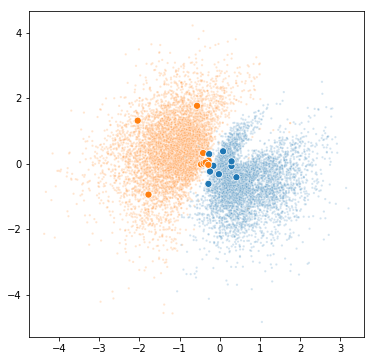

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9109 | Val loss 0.2180 


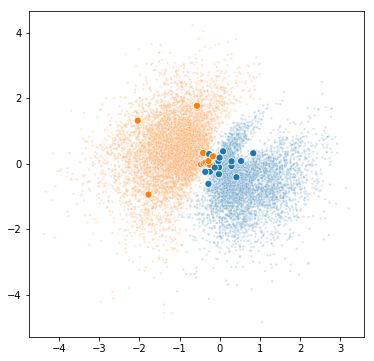

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9073 | Val loss 0.2702 


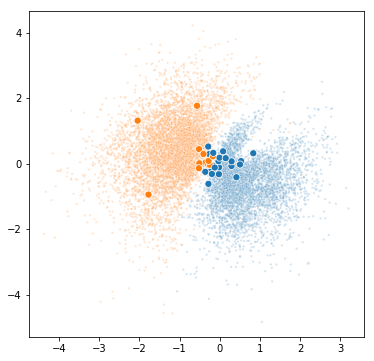

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9313 | Val loss 0.1734 


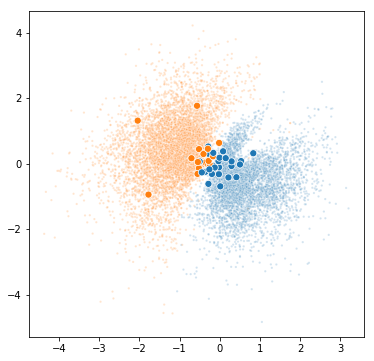

In [8]:
experiments_mnist(SearchActiveLearner,
                  DensityWeightedUncertainty(density=MultivariateLogProb(latent_dim)),
                  'entr_dens_vae2')

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.9302 | Val loss 0.4169 


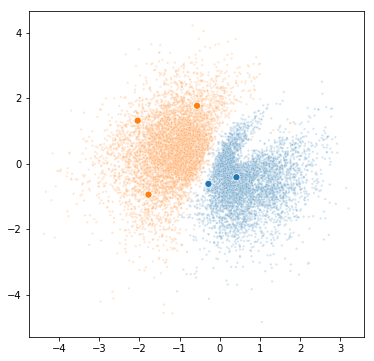

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.9682 | Val loss 0.1315 


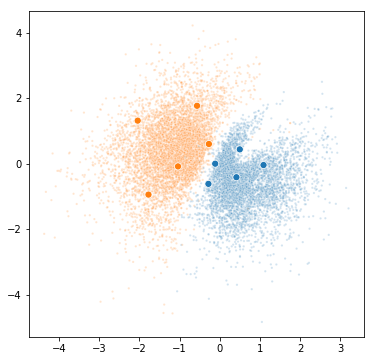

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9802 | Val loss 0.1466 


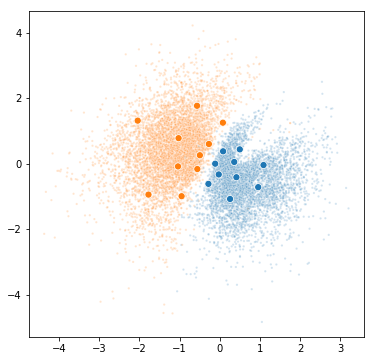

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9802 | Val loss 0.0819 


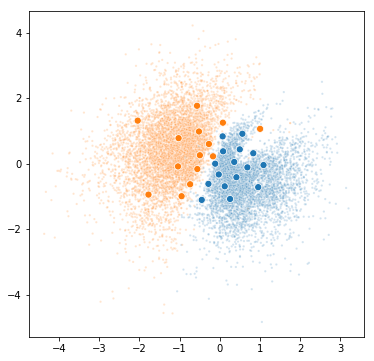

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9740 | Val loss 0.0710 


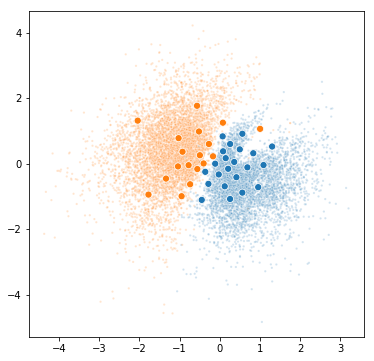

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9766 | Val loss 0.0736 


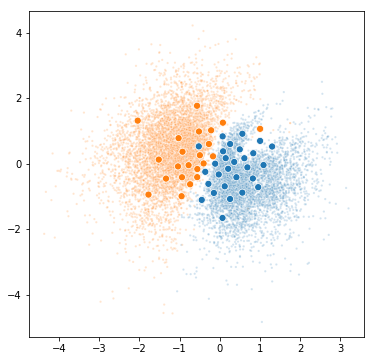

In [9]:
experiments_mnist(DiverstiyDensityUncertaintyActiveLearner,
                  DiversityDensityUncertainty(density=MultivariateLogProb(latent_dim)),
                  'div_dens_unc_vae2')


----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.7203 | Val loss 0.4510 


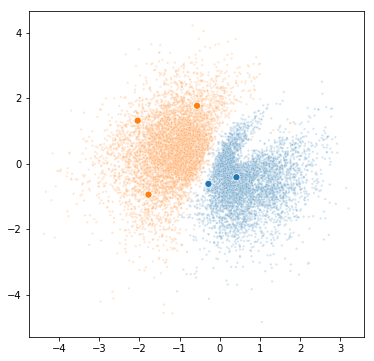

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.9286 | Val loss 0.1857 


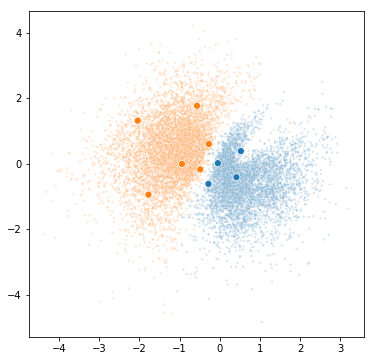

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9557 | Val loss 0.1248 


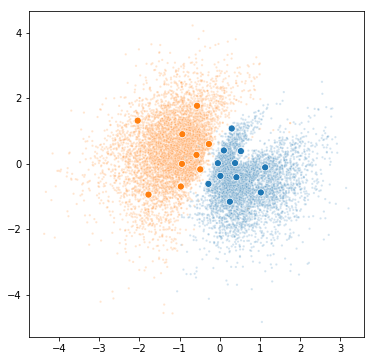

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9750 | Val loss 0.0702 


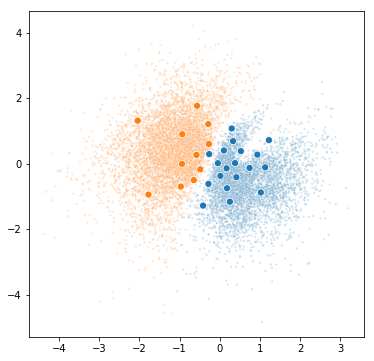

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9620 | Val loss 0.1018 


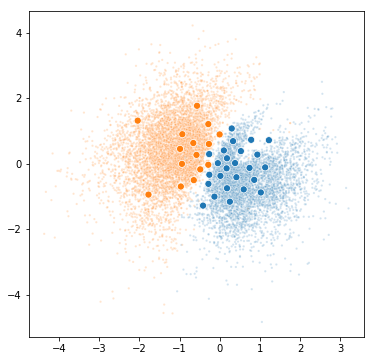

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9786 | Val loss 0.0603 


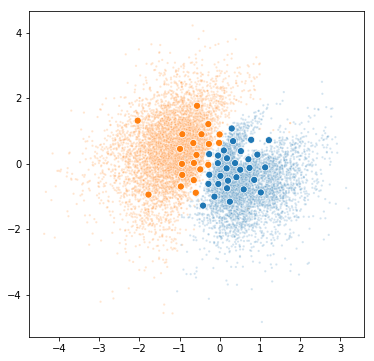

In [10]:
experiments_mnist(ModelAgnosticActiveLearner,
                  DiversityDensity(density=MultivariateLogProb(latent_dim)),
                  'div_dens_vae2')

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.5865 | Val loss 0.5646 


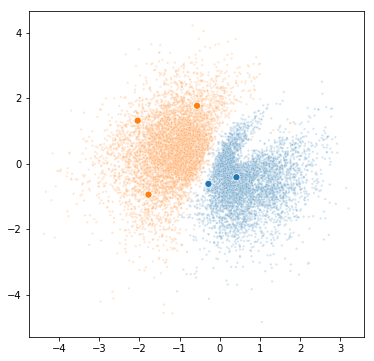

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.8568 | Val loss 0.3988 


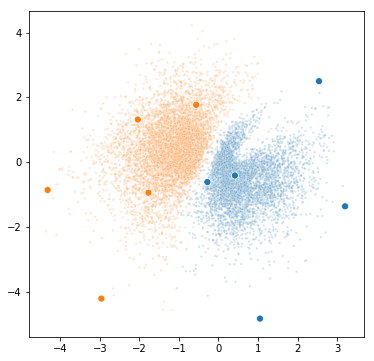

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.8953 | Val loss 0.2793 


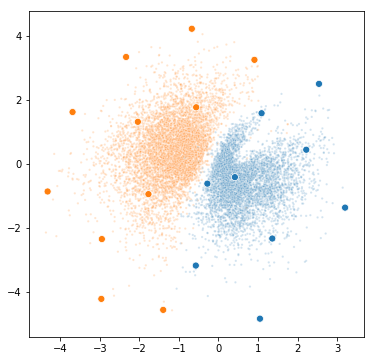

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9109 | Val loss 0.2257 


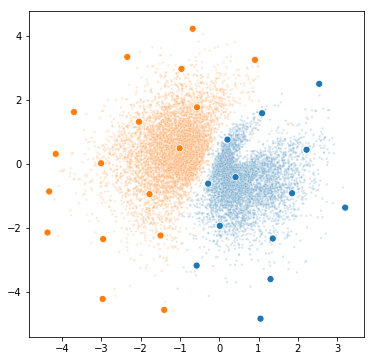

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9594 | Val loss 0.1058 


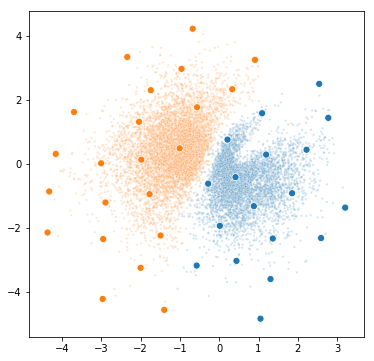

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9406 | Val loss 0.1485 


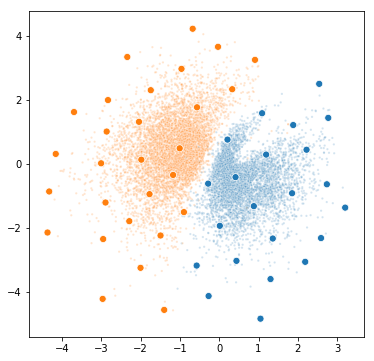

In [11]:
experiments_mnist(ModelAgnosticActiveLearner,
                  Diversity(),
                  'div_vae2')

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.9161 | Val loss 0.2558 


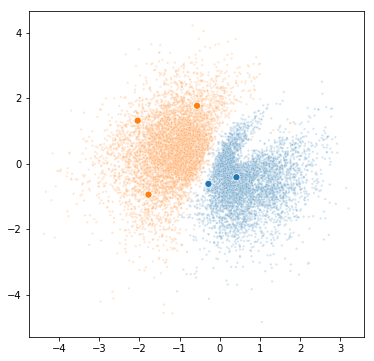

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.9630 | Val loss 0.1002 


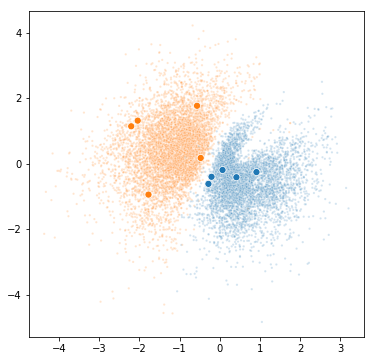

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9896 | Val loss 0.0491 


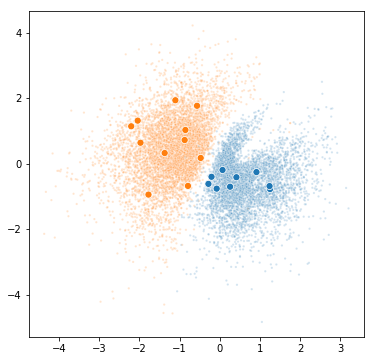

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9781 | Val loss 0.0561 


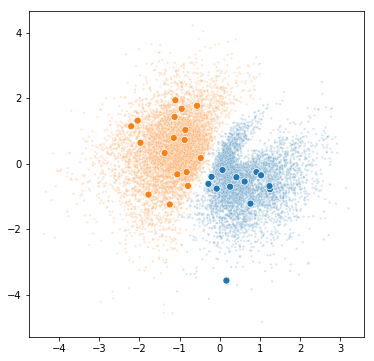

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9870 | Val loss 0.0351 


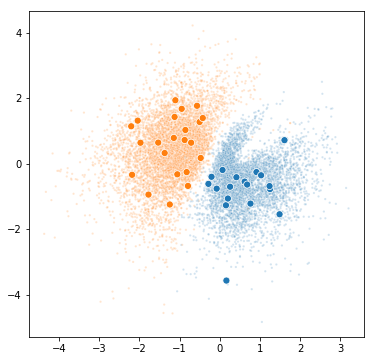

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9901 | Val loss 0.0279 


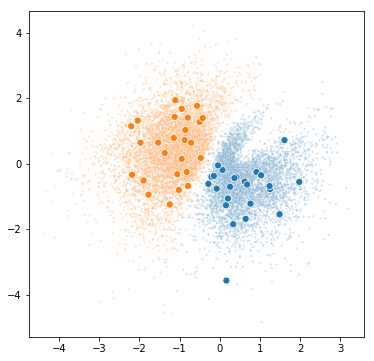

In [12]:
experiments_mnist(RandomActiveLearner,
                  None,
                  'rand_vae2')

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.6250 | Val loss 0.5850 


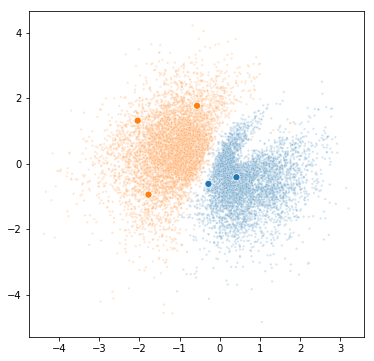

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.8964 | Val loss 0.2662 


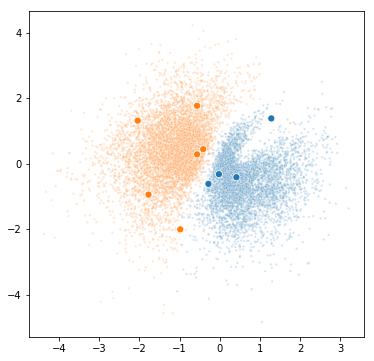

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9599 | Val loss 0.1287 


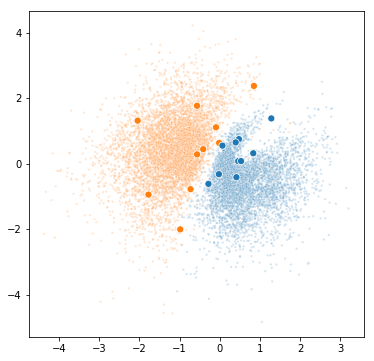

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9714 | Val loss 0.0886 


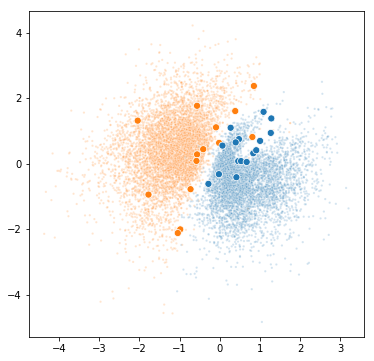

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.8167 | Val loss 0.4406 


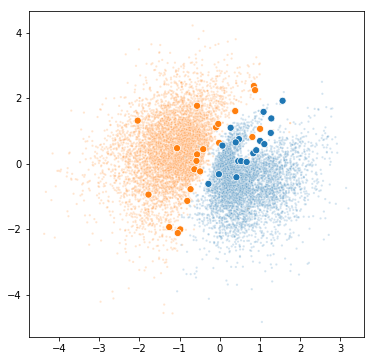

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9844 | Val loss 0.0946 


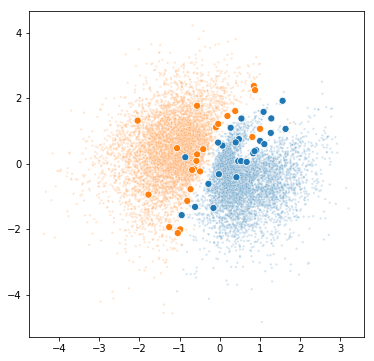

In [8]:
kwargs['temp'] = 0
experiments_mnist(SearchActiveLearner,
                  Entropy(),
                  'entr_vae2_t0.0')

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.9302 | Val loss 0.4169 


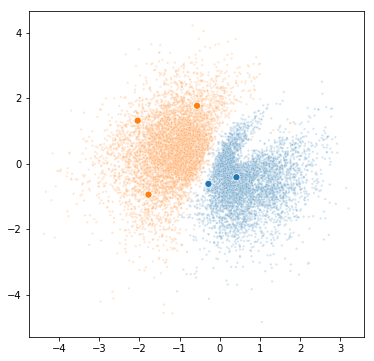

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.9193 | Val loss 0.1836 


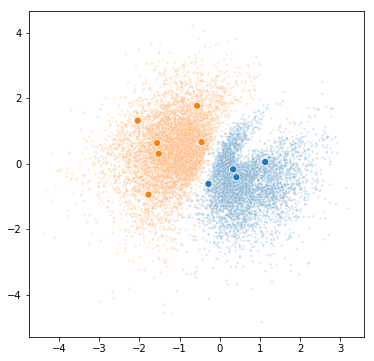

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9740 | Val loss 0.1197 


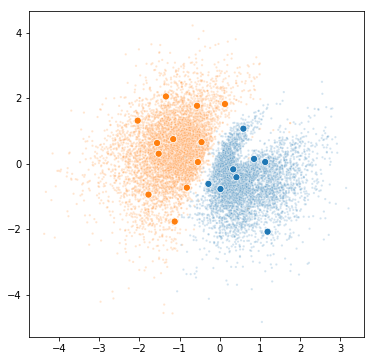

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9901 | Val loss 0.0500 


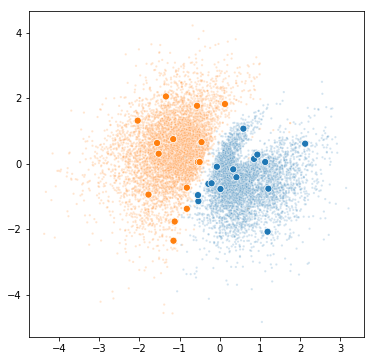

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9964 | Val loss 0.0133 


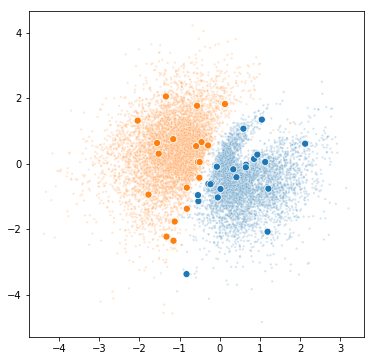

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9802 | Val loss 0.0758 


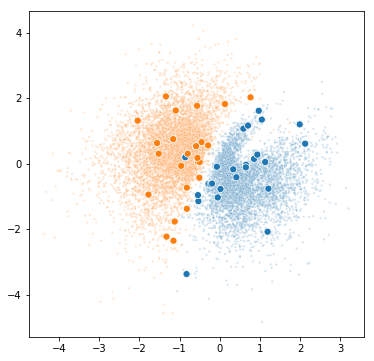

In [9]:
kwargs['temp'] = 0.25
experiments_mnist(SearchActiveLearner,
                  Entropy(),
                  'entr_vae2_t0.25')

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.7203 | Val loss 0.4510 


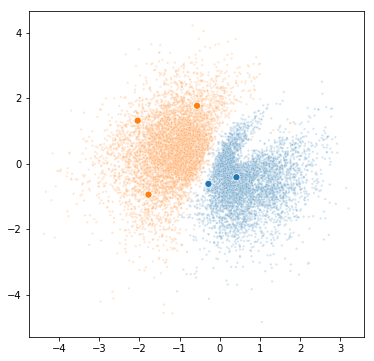

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.9703 | Val loss 0.1317 


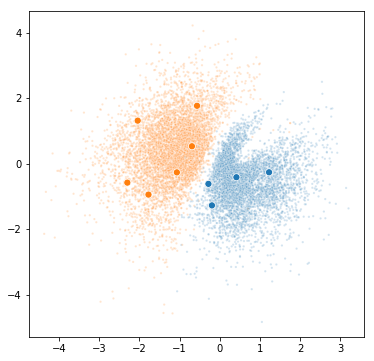

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9786 | Val loss 0.0642 


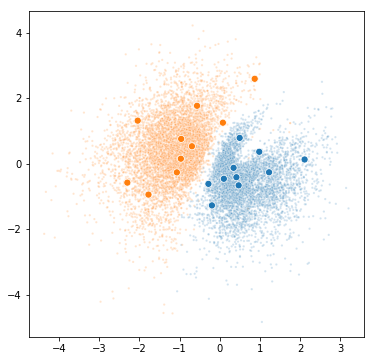

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9932 | Val loss 0.0504 


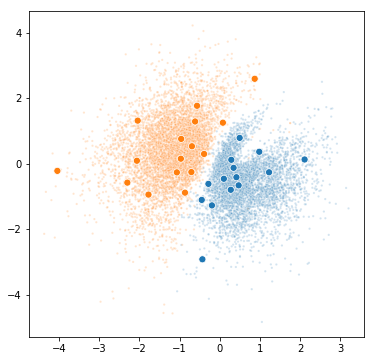

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9802 | Val loss 0.0575 


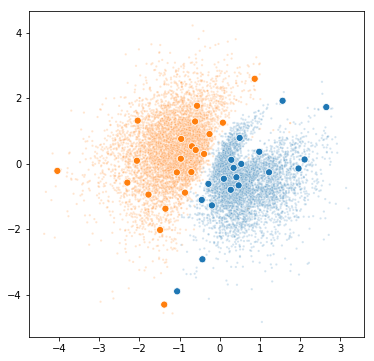

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9964 | Val loss 0.0260 


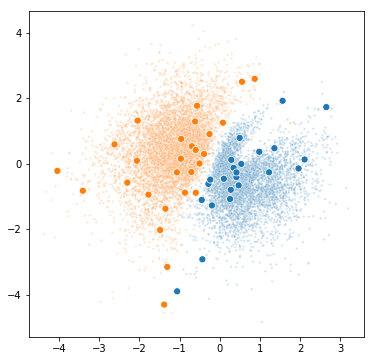

In [10]:
kwargs['temp'] = 0.5
experiments_mnist(SearchActiveLearner,
                  Entropy(),
                  'entr_vae2_t0.5')

----- Starting round 0 -----
Iteration: 5 | Total datapoints: 5 | Val Acc: 0.5865 | Val loss 0.5646 


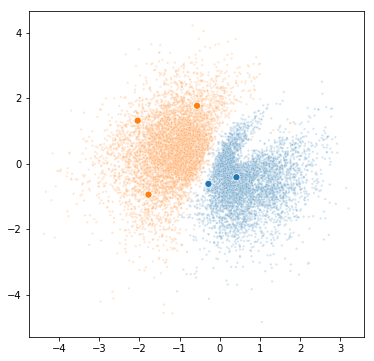

Iteration: 10 | Total datapoints: 10 | Val Acc: 0.9109 | Val loss 0.2441 


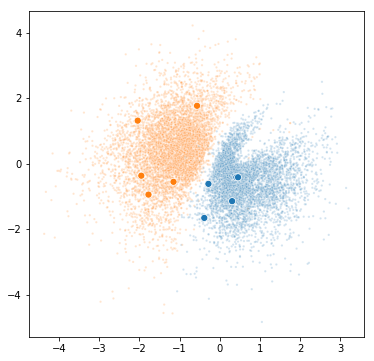

Iteration: 20 | Total datapoints: 20 | Val Acc: 0.9703 | Val loss 0.0921 


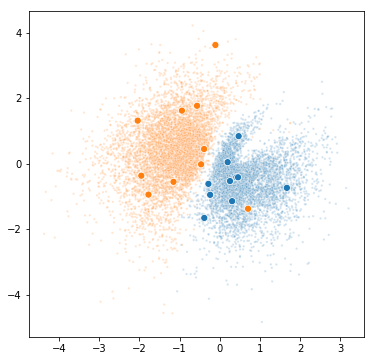

Iteration: 30 | Total datapoints: 30 | Val Acc: 0.9714 | Val loss 0.1125 


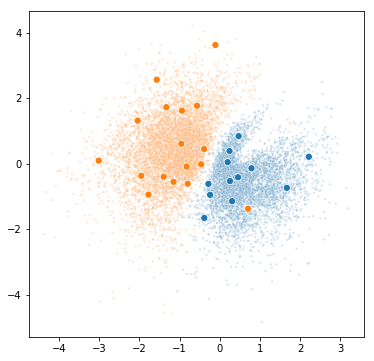

Iteration: 40 | Total datapoints: 40 | Val Acc: 0.9901 | Val loss 0.0297 


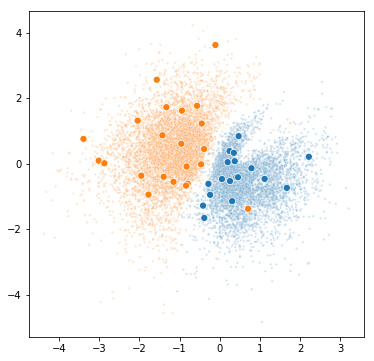

Iteration: 50 | Total datapoints: 50 | Val Acc: 0.9906 | Val loss 0.0362 


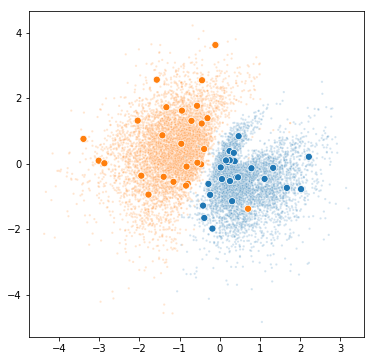

In [11]:
kwargs['temp'] = 1
experiments_mnist(SearchActiveLearner,
                  Entropy(),
                  'entr_vae2_t1.0')

In [14]:
#vae50 = torch.load('./models/MNIST_5_7/VAE_50.pth.tar',map_location=device)
#vae50.eval()
#with torch.no_grad():
#    z_train,_ = vae50.encode(X_train.view(X_train.shape[0],-1))
#    print(z_train.shape)
#vae50_dset = torch.utils.data.TensorDataset(
#    torch.tensor(X_train,dtype=torch.float),
#    torch.tensor(z_train,dtype=torch.float),
#    torch.tensor(y_train,dtype=torch.long))

### Establish Baselines

In [12]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
full_train_loader = torch.utils.data.DataLoader(train_set,batch_size=32, shuffle=True, **kwargs)
#test_loader = torch.utils.data.DataLoader(test_set,batch_size=32, shuffle=False, **kwargs)

accs = np.zeros((5,10))
for r in range(1):
    model = LeNet(output_dim=2).to(device)
    for epoch in range(10):
        for data,target in full_train_loader:
            model.train_model(data, target)
        val_acc,val_loss = model.test(test_loader,device)#test(model, test_loader, device)
        print(val_acc)
        accs[r,epoch] = val_acc
            
supervised_mean = accs.max()
#supervised_std = accs.std()


Test set: Accuracy: 1918/1920 (100%), Average loss: 0.0055
0.9989583333333333

Test set: Accuracy: 1918/1920 (100%), Average loss: 0.0060
0.9989583333333333

Test set: Accuracy: 1918/1920 (100%), Average loss: 0.0040
0.9989583333333333

Test set: Accuracy: 1919/1920 (100%), Average loss: 0.0029
0.9994791666666667

Test set: Accuracy: 1917/1920 (100%), Average loss: 0.0034
0.9984375

Test set: Accuracy: 1919/1920 (100%), Average loss: 0.0021
0.9994791666666667

Test set: Accuracy: 1919/1920 (100%), Average loss: 0.0011
0.9994791666666667

Test set: Accuracy: 1918/1920 (100%), Average loss: 0.0049
0.9989583333333333

Test set: Accuracy: 1919/1920 (100%), Average loss: 0.0010
0.9994791666666667

Test set: Accuracy: 1919/1920 (100%), Average loss: 0.0010
0.9994791666666667


### Plot results

In [20]:
#def x_range(arr, initial_label_pool_size):
#    return range(initial_label_pool_size, initial_label_pool_size+len(arr))
#def plot_it (means,stds,name,initial_label_pool_size): 
#    return plt.errorbar(x_range(means,initial_label_pool_size),means,yerr=stds,label=name)

In [21]:
##'div_dens_unc_vae50',
##'dens_vae50_out',
#fps = ['entr_dens_vae2_out',
#       'div_dens_unc_vae2']
#
##for i in [4,3,2,0]:
#plt.figure(figsize=(8,6))
#
#initial_label_pool_size = 0
#for fp in fps:    
#    _,_,mean,std = utils.load_obj(result_folder+fp)
#    plot_it(mean,std,fp,initial_label_pool_size)
#
#plt.xlabel('Accuracy')
#plt.ylabel('#labeled instances')
#plt.title('MNIST 5/7 no initially labeled instances')
#plt.legend(loc='lower right')
#plt.show()

In [22]:
## load results from file
#rand_mean, rand_std = utils.load_obj(result_folder+'rand')
#H_mean, H_std = utils.load_obj(result_folder+'H')
#dens_vae2_mean, dens_vae2_std = utils.load_obj(result_folder+'dens_vae_2')
#dens_vae5_mean, dens_vae5_std = utils.load_obj(result_folder+'dens_vae_5')
#dens_vae10_mean, dens_vae10_std = utils.load_obj(result_folder+'dens_vae_10')
#dens_vae25_mean, dens_vae25_std = utils.load_obj(result_folder+'dens_vae_25')
#dens_vae50_mean, dens_vae50_std = utils.load_obj(result_folder+'dens_vae_50')
#dens_vae100_mean, dens_vae100_std = utils.load_obj(result_folder+'dens_vae_100')